In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import nidaqmx

# Calibrate

In [5]:
with nidaqmx.Task() as aitask:
    aitask.ai_channels.add_ai_voltage_chan('Dev1/ai0')
    aitask.timing.cfg_samp_clk_timing(100.0)
      
    # read 10 samples
    data = aitask.read(10, timeout=1)

print("Voltage: {}+-{}".format(np.mean(data), np.std(data)))

Voltage: 2.278562510223702+-0.00021367023981235287


# Run tests

Generate a sample waveform. We have ao0 producing an output, which is sent to the Arduino, which modifies it in some way, and then the modified version is read on ai0

In [10]:
sampfreq = 100.0    # Hz
dur = 5    # sec
amp = 1 # V
freq = 0.5   # Hz

t = np.arange(0, dur, step=1.0/sampfreq)
outwave = amp * np.sin(2*np.pi*freq * t) + 1.5

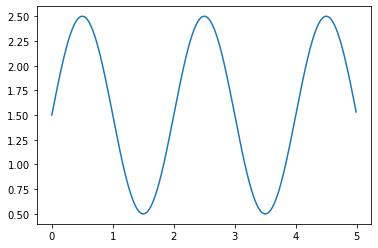

In [11]:
plt.plot(t, outwave)
plt.show()

In [14]:
with nidaqmx.Task() as aitask, nidaqmx.Task() as aotask:
    aitask.ai_channels.add_ai_voltage_chan('Dev1/ai0')
    aitask.timing.cfg_samp_clk_timing(sampfreq)
    
    aotask.ao_channels.add_ao_voltage_chan('Dev1/ao0')
    
    aotask.timing.cfg_samp_clk_timing(sampfreq, source=u"/Dev1/ai/SampleClock")
    aotask.write(outwave, auto_start=True)
    
    aitask.start()
    data = aitask.read(len(outwave), timeout=dur+1)

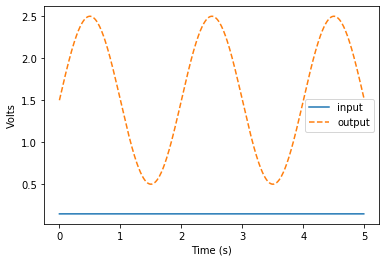

In [15]:
plt.plot(t, data, label='input')
plt.plot(t, outwave, '--', label='output')
plt.xlabel('Time (s)')
plt.ylabel('Volts')
plt.legend(loc='best')
# plt.xlim(0,1)
plt.show()